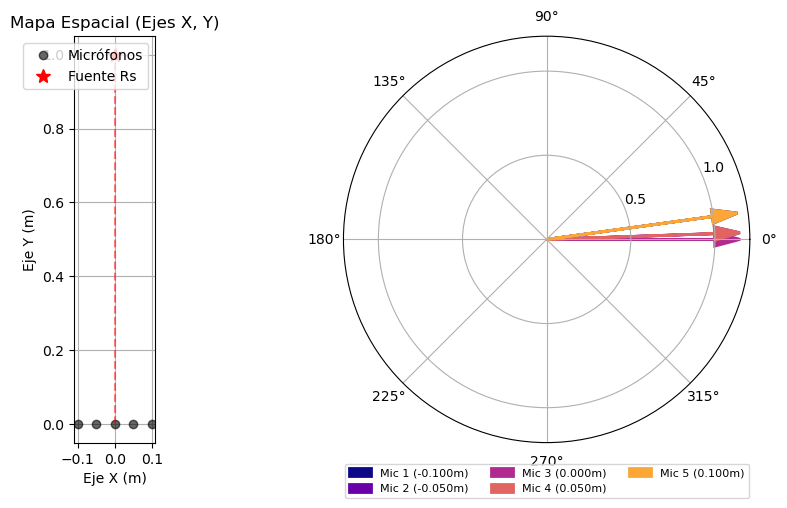


--- ¡EL INTERACTIVO ESTÁ CORRIENDO! Mueve los sliders y observa los fasores ---


interactive(children=(FloatSlider(value=1.0, description='Distancia r (m):', layout=Layout(width='400px'), max…

<function __main__.update_plot(r_source, theta_deg, f_hz)>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Layout
import warnings
from IPython.display import display

# Suprimir warnings comunes
warnings.filterwarnings('ignore', message='divide by zero encountered in log10')
warnings.filterwarnings('ignore', message='invalid value encountered in cdouble_scalars')


# --- 1. FUNCIÓN STEERING VECTOR (LÓGICA DE FASE ROBUSTA) ---

def near_field_steering_vector(f, Rs, fs, mic_array, K=1, c=343):
    """
    Calcula el steering vector (MK x 1) con TDOA explícito para robustez de fase.
    """
    
    f_scalar = np.atleast_1d(f)[0] 
    source_distance = np.linalg.norm(Rs)
    
    # 1. Distancias y Propagación
    distances = np.linalg.norm(mic_array - Rs.reshape(1, -1), axis = 1).reshape(-1, 1)

    # Cálculo del TDOA (Tiempo de Diferencia de Llegada) relativo al centro: (r_ms - r_s) / c
    mic_delay_relative = (distances - source_distance) / c 

    # 2. Normalización de Amplitud (r_s / r_ms)
    amplitude_factor_internal = source_distance / distances
    
    # 3. Retardos Taps (kT)
    T = 1/fs
    tabs = np.arange(K)
    tab_delay = tabs * T

    # TÉRMINO DE FASE TOTAL: (r_ms - r_s)/c - k*T
    total_time_diff = mic_delay_relative - tab_delay
    
    # Cálculo del Steering Vector (Amplitud * Fase)
    steering_vector = amplitude_factor_internal * np.exp(1j * 2 * np.pi * f_scalar * total_time_diff)
    
    # Colapsing la matriz
    normalized_steering_vector = steering_vector.reshape(-1,1)

    return normalized_steering_vector


# --- 2. CONFIGURACIÓN DEL ARREGLO Y CONSTANTES ---

M = 5 
d_spacing = 0.05 
mic_array_pos = np.linspace(-(M - 1) * d_spacing / 2, (M - 1) * d_spacing / 2, M)
mic_array_test = np.zeros((M, 3))
mic_array_test[:, 0] = mic_array_pos 

fs_test = 8000.0   
c_test = 343.0     
K_test = 1 

# Inicialización de variables para la optimización global
plot_data = {'arrows': [], 'source_point': None, 'source_line': None, 'ax1': None, 'ax2': None}

r_initial = 1.0
theta_initial = np.deg2rad(90)
Rs_initial = np.array([r_initial * np.cos(theta_initial), r_initial * np.sin(theta_initial), 0.0])


# --- 3. FUNCIONES DE PLOTEO OPTIMIZADO ---

def setup_plot():
    """Inicializa la figura de Matplotlib y guarda las referencias a los objetos."""
    global plot_data
    
    # FIGURA REDUCIDA
    fig = plt.figure(figsize=(10, 5)) 
    
    # SUBPLOT 1: MAPA ESPACIAL (2D)
    ax1 = fig.add_subplot(121)
    ax1.plot(mic_array_test[:, 0], mic_array_test[:, 1], 'o', color='black', alpha=0.6, label='Micrófonos')
    
    source_point, = ax1.plot([Rs_initial[0]], [Rs_initial[1]], 'r*', markersize=10, label='Fuente Rs')
    source_line, = ax1.plot([0, Rs_initial[0]], [0, Rs_initial[1]], 'r--', alpha=0.5)
    
    ax1.set_title('Mapa Espacial (Ejes X, Y)')
    ax1.set_xlabel('Eje X (m)')
    ax1.set_ylabel('Eje Y (m)')
    ax1.set_aspect('equal', adjustable='box')
    ax1.grid(True)
    ax1.legend(loc='upper right')
    plot_data['ax1'] = ax1
    plot_data['source_point'] = source_point
    plot_data['source_line'] = source_line

    
    # SUBPLOT 2: FASORES (Plano Polar, Reducido)
    ax2 = fig.add_subplot(122, projection='polar')
    ax2.set_theta_zero_location("E") 
    ax2.set_rticks([0.5, 1.0])
    ax2.set_rmax(1.2)
    ax2.grid(True)
    plot_data['ax2'] = ax2
    
    # Generamos un steering vector inicial para que los fasores no inicien en 0
    a_init = near_field_steering_vector(1500, Rs_initial, fs_test, mic_array_test, K=1, c=c_test)
    
    arrows = []
    for i in range(M):
        color = plt.cm.plasma(i/M) 
        angle_init = np.angle(a_init[i, 0])
        amp_init = np.abs(a_init[i, 0])
        
        arrow = ax2.arrow(angle_init, 0, 0, amp_init, head_width=0.08, head_length=0.15, 
                         fc=color, ec=color, linewidth=2, 
                         label=f'Mic {i+1} ({mic_array_test[i, 0]:.3f}m)')
        arrows.append(arrow)
    
    plot_data['arrows'] = arrows
    ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=8) # Leyenda debajo
    
    plt.tight_layout()
    plt.show()


def update_plot(r_source, theta_deg, f_hz):
    """Actualiza los datos de los objetos de Matplotlib sin redibujar la figura."""
    global plot_data
    
    print(f"\n--- INICIO CÁLCULO: r={r_source:.2f}m, θ={theta_deg:.0f}°, f={f_hz:.0f}Hz ---")
    
    theta_rad = np.deg2rad(theta_deg)
    
    Rs = np.array([
        r_source * np.cos(theta_rad), 
        r_source * np.sin(theta_rad), 
        0.0
    ])

    a_mk = near_field_steering_vector(f_hz, Rs, fs_test, mic_array_test, K=K_test, c=c_test)
    a_vector = a_mk[:, 0]
    
    # --- 1. ACTUALIZAR MAPA ESPACIAL (Zoom Dinámico) ---
    ax1 = plot_data['ax1']
    
    # Actualizar punto y línea
    plot_data['source_point'].set_data([Rs[0]], [Rs[1]]) 
    plot_data['source_line'].set_data([0, Rs[0]], [0, Rs[1]])
    
    # Ajuste de Zoom Automático
    max_coord = max(r_source, np.max(np.abs(mic_array_test[:, 0])))
    r_limit = max_coord * 1.1 
    ax1.set_xlim([-r_limit, r_limit])
    ax1.set_ylim([-r_limit, r_limit])
    
    # --- 2. ACTUALIZAR FASORES (Plano Polar) ---
    ax2 = plot_data['ax2']
    
    for i in range(M):
        angle = np.angle(a_vector[i])
        amplitude = np.abs(a_vector[i])
        
        arrow = plot_data['arrows'][i]
        
        # Eliminamos la flecha antigua y dibujamos la nueva para garantizar la fluidez polar
        arrow.remove()
        
        new_arrow = ax2.arrow(
            angle, 
            0, 
            0, 
            amplitude, 
            head_width=0.08,
            head_length=0.15,
            fc=arrow.get_facecolor(), 
            ec=arrow.get_edgecolor(),
            linewidth=2
        )
        plot_data['arrows'][i] = new_arrow

    ax2.set_title(f'Fasores del Steering Vector $\\mathbf{{a}}$ ($K=1$) \n Fuente: r={r_source:.2f}m, $\\theta={theta_deg:.0f}^\circ$', va='bottom', fontsize=12)

    # Forzar el redibujado. Esta es la parte que necesita funcionar en tu entorno.
    plt.draw()
    plt.pause(0.001) 
    
    # Imprimir diagnóstico
    print(f"--- FASE CENTRAL FINAL: {np.angle(a_vector[M//2])*180/np.pi:.4f}° ---")


# --- 4. EJECUCIÓN DEL SETUP Y EL INTERACT ---

# 1. Inicializar la figura y los objetos gráficos
setup_plot()

# 2. Definición de Sliders
r_slider = FloatSlider(min=0.2, max=3.0, step=0.1, value=r_initial, description='Distancia r (m):', layout=Layout(width='400px'))
theta_slider = FloatSlider(min=0, max=180, step=5, value=90, description='Ángulo θ (grados):', layout=Layout(width='400px'))
f_slider = FloatSlider(min=500, max=4000, step=100, value=1500, description='Frecuencia f (Hz):', layout=Layout(width='400px'))


# 3. Ejecutar el interact
print("\n--- ¡EL INTERACTIVO ESTÁ CORRIENDO! Mueve los sliders y observa los fasores ---")
interact(update_plot, 
         r_source=r_slider,
         theta_deg=theta_slider,
         f_hz=f_slider
        )